# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


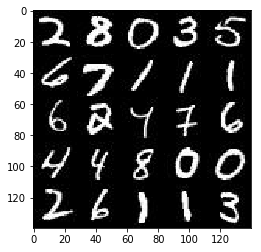

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

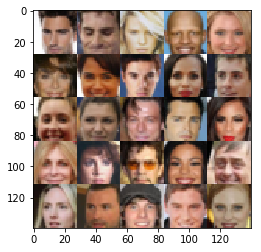

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [27]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [28]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # now 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # now 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out,logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every=10
    show_every = 100
    
    input_real, input_z, l_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size): 
                batch_images *= 2.0
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                # TODO: Train Model
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})
                
                if steps % print_every ==0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i+1, epoch_count),
                          'Batch {}...'.format(steps),
                         'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                steps += 1
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 0... Discriminator Loss: 3.3904... Generator Loss: 0.0445


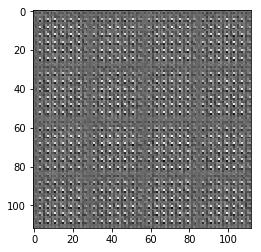

Epoch 1/2... Batch 10... Discriminator Loss: 0.0066... Generator Loss: 6.6837
Epoch 1/2... Batch 20... Discriminator Loss: 2.0143... Generator Loss: 0.1980
Epoch 1/2... Batch 30... Discriminator Loss: 0.5860... Generator Loss: 4.5037
Epoch 1/2... Batch 40... Discriminator Loss: 0.3452... Generator Loss: 3.4243
Epoch 1/2... Batch 50... Discriminator Loss: 0.4512... Generator Loss: 2.7949
Epoch 1/2... Batch 60... Discriminator Loss: 0.0285... Generator Loss: 4.3631
Epoch 1/2... Batch 70... Discriminator Loss: 0.9686... Generator Loss: 2.2281
Epoch 1/2... Batch 80... Discriminator Loss: 0.7397... Generator Loss: 1.5835
Epoch 1/2... Batch 90... Discriminator Loss: 1.7379... Generator Loss: 0.3407
Epoch 1/2... Batch 100... Discriminator Loss: 0.9720... Generator Loss: 0.9207


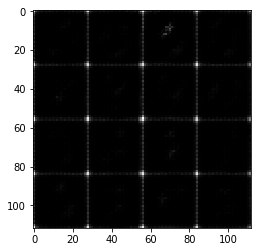

Epoch 1/2... Batch 110... Discriminator Loss: 0.8643... Generator Loss: 1.3239
Epoch 1/2... Batch 120... Discriminator Loss: 0.9182... Generator Loss: 0.9715
Epoch 1/2... Batch 130... Discriminator Loss: 1.1843... Generator Loss: 0.7976
Epoch 1/2... Batch 140... Discriminator Loss: 0.9734... Generator Loss: 0.8051
Epoch 1/2... Batch 150... Discriminator Loss: 1.7156... Generator Loss: 0.2545
Epoch 1/2... Batch 160... Discriminator Loss: 0.8231... Generator Loss: 1.1414
Epoch 1/2... Batch 170... Discriminator Loss: 0.7164... Generator Loss: 1.2429
Epoch 1/2... Batch 180... Discriminator Loss: 0.9418... Generator Loss: 1.3121
Epoch 1/2... Batch 190... Discriminator Loss: 1.7045... Generator Loss: 2.4961
Epoch 1/2... Batch 200... Discriminator Loss: 1.1379... Generator Loss: 1.3064


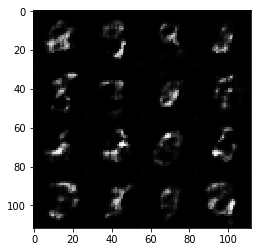

Epoch 1/2... Batch 210... Discriminator Loss: 1.4320... Generator Loss: 0.6320
Epoch 1/2... Batch 220... Discriminator Loss: 1.1858... Generator Loss: 1.3556
Epoch 1/2... Batch 230... Discriminator Loss: 1.1426... Generator Loss: 0.6472
Epoch 1/2... Batch 240... Discriminator Loss: 0.9806... Generator Loss: 0.8563
Epoch 1/2... Batch 250... Discriminator Loss: 1.2214... Generator Loss: 0.7718
Epoch 1/2... Batch 260... Discriminator Loss: 1.1225... Generator Loss: 0.6326
Epoch 1/2... Batch 270... Discriminator Loss: 1.1294... Generator Loss: 0.7520
Epoch 1/2... Batch 280... Discriminator Loss: 1.1233... Generator Loss: 0.6961
Epoch 1/2... Batch 290... Discriminator Loss: 1.2854... Generator Loss: 0.5387
Epoch 1/2... Batch 300... Discriminator Loss: 1.0689... Generator Loss: 0.8941


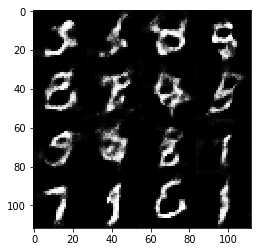

Epoch 1/2... Batch 310... Discriminator Loss: 1.2384... Generator Loss: 0.5913
Epoch 1/2... Batch 320... Discriminator Loss: 1.2096... Generator Loss: 0.5571
Epoch 1/2... Batch 330... Discriminator Loss: 1.0115... Generator Loss: 0.9947
Epoch 1/2... Batch 340... Discriminator Loss: 1.3426... Generator Loss: 1.7094
Epoch 1/2... Batch 350... Discriminator Loss: 1.3561... Generator Loss: 0.4167
Epoch 1/2... Batch 360... Discriminator Loss: 1.1870... Generator Loss: 0.6330
Epoch 1/2... Batch 370... Discriminator Loss: 1.1184... Generator Loss: 0.8337
Epoch 1/2... Batch 380... Discriminator Loss: 1.3237... Generator Loss: 0.4634
Epoch 1/2... Batch 390... Discriminator Loss: 1.1007... Generator Loss: 0.9955
Epoch 1/2... Batch 400... Discriminator Loss: 1.2027... Generator Loss: 0.6193


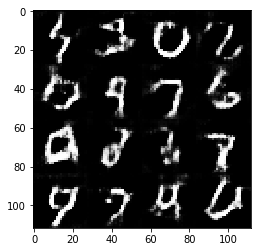

Epoch 1/2... Batch 410... Discriminator Loss: 1.3284... Generator Loss: 0.4655
Epoch 1/2... Batch 420... Discriminator Loss: 1.0889... Generator Loss: 0.7721
Epoch 1/2... Batch 430... Discriminator Loss: 1.2617... Generator Loss: 0.5260
Epoch 1/2... Batch 440... Discriminator Loss: 1.1984... Generator Loss: 0.5686
Epoch 1/2... Batch 450... Discriminator Loss: 1.1691... Generator Loss: 1.3756
Epoch 1/2... Batch 460... Discriminator Loss: 1.0662... Generator Loss: 1.1863
Epoch 1/2... Batch 470... Discriminator Loss: 1.1425... Generator Loss: 0.5719
Epoch 1/2... Batch 480... Discriminator Loss: 1.1046... Generator Loss: 1.0657
Epoch 1/2... Batch 490... Discriminator Loss: 1.2261... Generator Loss: 0.4923
Epoch 1/2... Batch 500... Discriminator Loss: 1.0365... Generator Loss: 0.7573


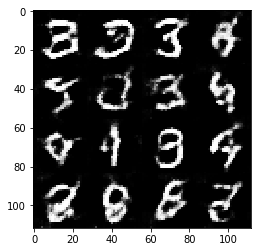

Epoch 1/2... Batch 510... Discriminator Loss: 0.9648... Generator Loss: 0.8437
Epoch 1/2... Batch 520... Discriminator Loss: 1.1682... Generator Loss: 0.6182
Epoch 1/2... Batch 530... Discriminator Loss: 1.4014... Generator Loss: 0.3798
Epoch 1/2... Batch 540... Discriminator Loss: 1.1065... Generator Loss: 0.7243
Epoch 1/2... Batch 550... Discriminator Loss: 1.5903... Generator Loss: 0.3080
Epoch 1/2... Batch 560... Discriminator Loss: 0.9717... Generator Loss: 0.9097
Epoch 1/2... Batch 570... Discriminator Loss: 1.5255... Generator Loss: 0.3197
Epoch 1/2... Batch 580... Discriminator Loss: 0.9910... Generator Loss: 1.3387
Epoch 1/2... Batch 590... Discriminator Loss: 0.9885... Generator Loss: 1.4918
Epoch 1/2... Batch 600... Discriminator Loss: 1.1095... Generator Loss: 0.9201


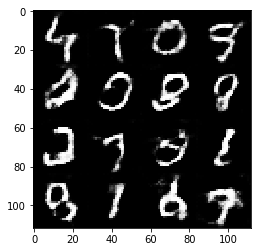

Epoch 1/2... Batch 610... Discriminator Loss: 1.0933... Generator Loss: 0.6550
Epoch 1/2... Batch 620... Discriminator Loss: 0.8115... Generator Loss: 1.3583
Epoch 1/2... Batch 630... Discriminator Loss: 0.9107... Generator Loss: 1.2495
Epoch 1/2... Batch 640... Discriminator Loss: 1.1573... Generator Loss: 0.5401
Epoch 1/2... Batch 650... Discriminator Loss: 1.1629... Generator Loss: 0.5402
Epoch 1/2... Batch 660... Discriminator Loss: 1.0690... Generator Loss: 0.7897
Epoch 1/2... Batch 670... Discriminator Loss: 1.0110... Generator Loss: 1.1640
Epoch 1/2... Batch 680... Discriminator Loss: 0.8752... Generator Loss: 1.1871
Epoch 1/2... Batch 690... Discriminator Loss: 1.4169... Generator Loss: 0.3432
Epoch 1/2... Batch 700... Discriminator Loss: 0.9631... Generator Loss: 1.1138


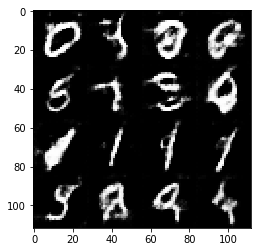

Epoch 1/2... Batch 710... Discriminator Loss: 0.8835... Generator Loss: 1.1837
Epoch 1/2... Batch 720... Discriminator Loss: 0.9190... Generator Loss: 0.8995
Epoch 1/2... Batch 730... Discriminator Loss: 1.1117... Generator Loss: 0.5854
Epoch 1/2... Batch 740... Discriminator Loss: 0.9070... Generator Loss: 1.0912
Epoch 1/2... Batch 750... Discriminator Loss: 0.9128... Generator Loss: 0.7981
Epoch 1/2... Batch 760... Discriminator Loss: 0.8865... Generator Loss: 0.9083
Epoch 1/2... Batch 770... Discriminator Loss: 1.1077... Generator Loss: 0.5554
Epoch 1/2... Batch 780... Discriminator Loss: 1.1783... Generator Loss: 0.5499
Epoch 1/2... Batch 790... Discriminator Loss: 1.0074... Generator Loss: 0.6911
Epoch 1/2... Batch 800... Discriminator Loss: 1.1555... Generator Loss: 0.6088


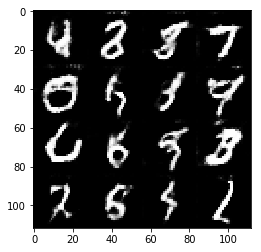

Epoch 1/2... Batch 810... Discriminator Loss: 0.9875... Generator Loss: 1.6266
Epoch 1/2... Batch 820... Discriminator Loss: 0.9063... Generator Loss: 1.4560
Epoch 1/2... Batch 830... Discriminator Loss: 1.0877... Generator Loss: 1.1483
Epoch 1/2... Batch 840... Discriminator Loss: 1.0206... Generator Loss: 0.8228
Epoch 1/2... Batch 850... Discriminator Loss: 1.0807... Generator Loss: 0.7050
Epoch 1/2... Batch 860... Discriminator Loss: 1.1635... Generator Loss: 0.5697
Epoch 1/2... Batch 870... Discriminator Loss: 2.4890... Generator Loss: 0.1212
Epoch 1/2... Batch 880... Discriminator Loss: 0.8318... Generator Loss: 1.0814
Epoch 1/2... Batch 890... Discriminator Loss: 0.8391... Generator Loss: 0.8894
Epoch 1/2... Batch 900... Discriminator Loss: 1.6277... Generator Loss: 0.2862


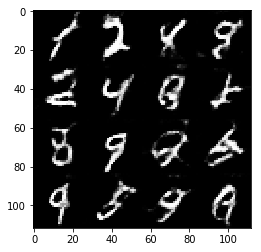

Epoch 1/2... Batch 910... Discriminator Loss: 1.0849... Generator Loss: 0.6195
Epoch 1/2... Batch 920... Discriminator Loss: 0.7514... Generator Loss: 1.4646
Epoch 1/2... Batch 930... Discriminator Loss: 1.1148... Generator Loss: 0.9963
Epoch 2/2... Batch 0... Discriminator Loss: 0.9522... Generator Loss: 0.8394


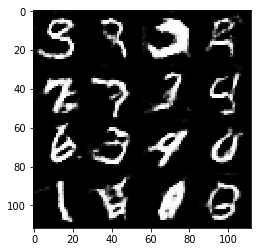

Epoch 2/2... Batch 10... Discriminator Loss: 1.0974... Generator Loss: 0.6114
Epoch 2/2... Batch 20... Discriminator Loss: 0.8327... Generator Loss: 0.8967
Epoch 2/2... Batch 30... Discriminator Loss: 2.0263... Generator Loss: 0.2559
Epoch 2/2... Batch 40... Discriminator Loss: 1.1219... Generator Loss: 0.6003
Epoch 2/2... Batch 50... Discriminator Loss: 0.7307... Generator Loss: 1.0759
Epoch 2/2... Batch 60... Discriminator Loss: 1.8458... Generator Loss: 0.2444
Epoch 2/2... Batch 70... Discriminator Loss: 0.7936... Generator Loss: 1.3237
Epoch 2/2... Batch 80... Discriminator Loss: 1.3109... Generator Loss: 0.4512
Epoch 2/2... Batch 90... Discriminator Loss: 1.1389... Generator Loss: 0.6042
Epoch 2/2... Batch 100... Discriminator Loss: 1.1210... Generator Loss: 1.9859


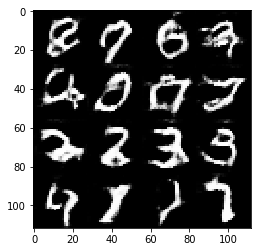

Epoch 2/2... Batch 110... Discriminator Loss: 0.8665... Generator Loss: 0.9392
Epoch 2/2... Batch 120... Discriminator Loss: 1.1448... Generator Loss: 0.5284
Epoch 2/2... Batch 130... Discriminator Loss: 1.6071... Generator Loss: 0.2976
Epoch 2/2... Batch 140... Discriminator Loss: 1.0852... Generator Loss: 0.5704
Epoch 2/2... Batch 150... Discriminator Loss: 0.8887... Generator Loss: 1.3395
Epoch 2/2... Batch 160... Discriminator Loss: 1.1580... Generator Loss: 0.5132
Epoch 2/2... Batch 170... Discriminator Loss: 0.9563... Generator Loss: 0.7494
Epoch 2/2... Batch 180... Discriminator Loss: 1.2472... Generator Loss: 2.9007
Epoch 2/2... Batch 190... Discriminator Loss: 0.7774... Generator Loss: 1.1454
Epoch 2/2... Batch 200... Discriminator Loss: 0.9872... Generator Loss: 0.9878


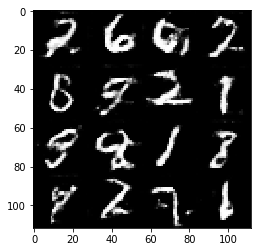

Epoch 2/2... Batch 210... Discriminator Loss: 1.0292... Generator Loss: 0.6565
Epoch 2/2... Batch 220... Discriminator Loss: 1.0925... Generator Loss: 0.5545
Epoch 2/2... Batch 230... Discriminator Loss: 2.4293... Generator Loss: 0.1279
Epoch 2/2... Batch 240... Discriminator Loss: 0.7704... Generator Loss: 0.9090
Epoch 2/2... Batch 250... Discriminator Loss: 0.7583... Generator Loss: 1.2798
Epoch 2/2... Batch 260... Discriminator Loss: 2.2698... Generator Loss: 0.1538
Epoch 2/2... Batch 270... Discriminator Loss: 2.0219... Generator Loss: 0.2058
Epoch 2/2... Batch 280... Discriminator Loss: 0.8261... Generator Loss: 0.9967
Epoch 2/2... Batch 290... Discriminator Loss: 1.2102... Generator Loss: 1.6028
Epoch 2/2... Batch 300... Discriminator Loss: 0.7754... Generator Loss: 0.9153


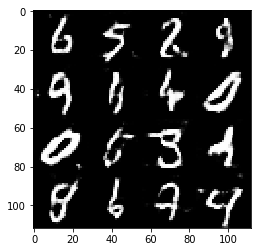

Epoch 2/2... Batch 310... Discriminator Loss: 0.7251... Generator Loss: 1.0301
Epoch 2/2... Batch 320... Discriminator Loss: 0.9728... Generator Loss: 0.6786
Epoch 2/2... Batch 330... Discriminator Loss: 0.7901... Generator Loss: 1.0171
Epoch 2/2... Batch 340... Discriminator Loss: 0.8502... Generator Loss: 1.0062
Epoch 2/2... Batch 350... Discriminator Loss: 1.1150... Generator Loss: 1.4815
Epoch 2/2... Batch 360... Discriminator Loss: 0.8226... Generator Loss: 0.9286
Epoch 2/2... Batch 370... Discriminator Loss: 0.6834... Generator Loss: 1.5065
Epoch 2/2... Batch 380... Discriminator Loss: 0.8997... Generator Loss: 0.9061
Epoch 2/2... Batch 390... Discriminator Loss: 0.9808... Generator Loss: 1.5873
Epoch 2/2... Batch 400... Discriminator Loss: 0.6271... Generator Loss: 1.0931


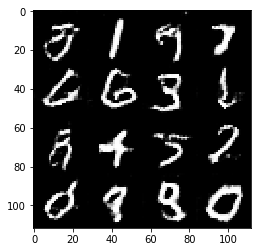

Epoch 2/2... Batch 410... Discriminator Loss: 1.0836... Generator Loss: 0.6265
Epoch 2/2... Batch 420... Discriminator Loss: 0.6293... Generator Loss: 1.3927
Epoch 2/2... Batch 430... Discriminator Loss: 1.2048... Generator Loss: 0.7522
Epoch 2/2... Batch 440... Discriminator Loss: 0.9290... Generator Loss: 0.8143
Epoch 2/2... Batch 450... Discriminator Loss: 0.8462... Generator Loss: 1.4989
Epoch 2/2... Batch 460... Discriminator Loss: 0.7368... Generator Loss: 1.6367
Epoch 2/2... Batch 470... Discriminator Loss: 0.8780... Generator Loss: 0.7859
Epoch 2/2... Batch 480... Discriminator Loss: 0.8431... Generator Loss: 1.0033
Epoch 2/2... Batch 490... Discriminator Loss: 0.7635... Generator Loss: 1.1721
Epoch 2/2... Batch 500... Discriminator Loss: 0.5901... Generator Loss: 1.4363


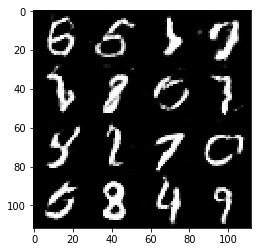

Epoch 2/2... Batch 510... Discriminator Loss: 0.7043... Generator Loss: 1.0117
Epoch 2/2... Batch 520... Discriminator Loss: 0.7439... Generator Loss: 0.9616
Epoch 2/2... Batch 530... Discriminator Loss: 1.0128... Generator Loss: 0.6915
Epoch 2/2... Batch 540... Discriminator Loss: 1.4347... Generator Loss: 0.3613
Epoch 2/2... Batch 550... Discriminator Loss: 2.8741... Generator Loss: 4.4035
Epoch 2/2... Batch 560... Discriminator Loss: 0.9722... Generator Loss: 0.9540
Epoch 2/2... Batch 570... Discriminator Loss: 0.8660... Generator Loss: 1.4598
Epoch 2/2... Batch 580... Discriminator Loss: 0.6921... Generator Loss: 1.1905
Epoch 2/2... Batch 590... Discriminator Loss: 0.8456... Generator Loss: 2.0605
Epoch 2/2... Batch 600... Discriminator Loss: 1.5584... Generator Loss: 0.3472


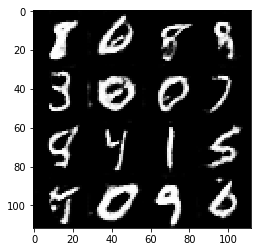

Epoch 2/2... Batch 610... Discriminator Loss: 1.3140... Generator Loss: 0.5026
Epoch 2/2... Batch 620... Discriminator Loss: 0.7423... Generator Loss: 1.2067
Epoch 2/2... Batch 630... Discriminator Loss: 0.5859... Generator Loss: 1.3955
Epoch 2/2... Batch 640... Discriminator Loss: 0.7270... Generator Loss: 1.0638
Epoch 2/2... Batch 650... Discriminator Loss: 0.9240... Generator Loss: 0.7883
Epoch 2/2... Batch 660... Discriminator Loss: 0.8028... Generator Loss: 0.8455
Epoch 2/2... Batch 670... Discriminator Loss: 0.9471... Generator Loss: 2.0812
Epoch 2/2... Batch 680... Discriminator Loss: 0.8223... Generator Loss: 0.9825
Epoch 2/2... Batch 690... Discriminator Loss: 1.3128... Generator Loss: 0.4945
Epoch 2/2... Batch 700... Discriminator Loss: 0.8717... Generator Loss: 0.7926


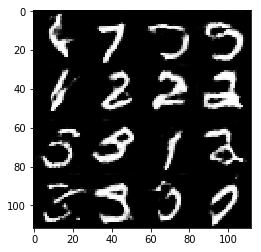

Epoch 2/2... Batch 710... Discriminator Loss: 1.1150... Generator Loss: 0.5258
Epoch 2/2... Batch 720... Discriminator Loss: 0.7660... Generator Loss: 0.8863
Epoch 2/2... Batch 730... Discriminator Loss: 2.8843... Generator Loss: 0.1122
Epoch 2/2... Batch 740... Discriminator Loss: 0.9181... Generator Loss: 0.9584
Epoch 2/2... Batch 750... Discriminator Loss: 0.8440... Generator Loss: 1.0167
Epoch 2/2... Batch 760... Discriminator Loss: 0.5228... Generator Loss: 1.4161
Epoch 2/2... Batch 770... Discriminator Loss: 0.7978... Generator Loss: 1.4608
Epoch 2/2... Batch 780... Discriminator Loss: 1.2362... Generator Loss: 0.5036
Epoch 2/2... Batch 790... Discriminator Loss: 0.7106... Generator Loss: 1.1126
Epoch 2/2... Batch 800... Discriminator Loss: 0.7930... Generator Loss: 0.9384


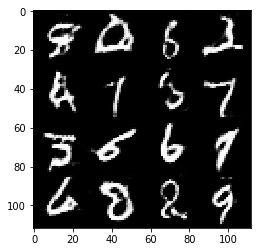

Epoch 2/2... Batch 810... Discriminator Loss: 0.9416... Generator Loss: 0.7638
Epoch 2/2... Batch 820... Discriminator Loss: 0.7754... Generator Loss: 2.2810
Epoch 2/2... Batch 830... Discriminator Loss: 1.6223... Generator Loss: 0.3290
Epoch 2/2... Batch 840... Discriminator Loss: 0.8093... Generator Loss: 1.6485
Epoch 2/2... Batch 850... Discriminator Loss: 1.0107... Generator Loss: 1.5866
Epoch 2/2... Batch 860... Discriminator Loss: 0.8170... Generator Loss: 1.7417
Epoch 2/2... Batch 870... Discriminator Loss: 1.2147... Generator Loss: 0.5664
Epoch 2/2... Batch 880... Discriminator Loss: 0.8248... Generator Loss: 0.9578
Epoch 2/2... Batch 890... Discriminator Loss: 0.6113... Generator Loss: 1.7197
Epoch 2/2... Batch 900... Discriminator Loss: 1.2221... Generator Loss: 0.5233


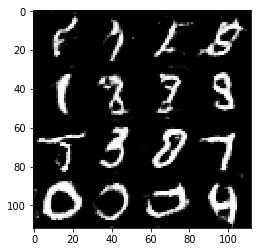

Epoch 2/2... Batch 910... Discriminator Loss: 1.3369... Generator Loss: 0.5043
Epoch 2/2... Batch 920... Discriminator Loss: 0.6165... Generator Loss: 1.3083
Epoch 2/2... Batch 930... Discriminator Loss: 2.1500... Generator Loss: 0.1981


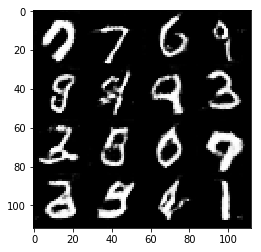

In [39]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 0... Discriminator Loss: 7.4252... Generator Loss: 0.0009


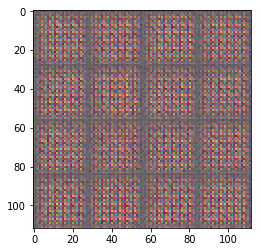

Epoch 1/1... Batch 10... Discriminator Loss: 0.0595... Generator Loss: 3.3074
Epoch 1/1... Batch 20... Discriminator Loss: 0.1223... Generator Loss: 2.9731
Epoch 1/1... Batch 30... Discriminator Loss: 0.0440... Generator Loss: 5.0680
Epoch 1/1... Batch 40... Discriminator Loss: 0.9017... Generator Loss: 18.8066
Epoch 1/1... Batch 50... Discriminator Loss: 0.0039... Generator Loss: 7.3542
Epoch 1/1... Batch 60... Discriminator Loss: 0.3984... Generator Loss: 1.4283
Epoch 1/1... Batch 70... Discriminator Loss: 0.9386... Generator Loss: 1.9897
Epoch 1/1... Batch 80... Discriminator Loss: 0.9565... Generator Loss: 6.9123
Epoch 1/1... Batch 90... Discriminator Loss: 1.0310... Generator Loss: 0.8423
Epoch 1/1... Batch 100... Discriminator Loss: 0.4129... Generator Loss: 2.0091


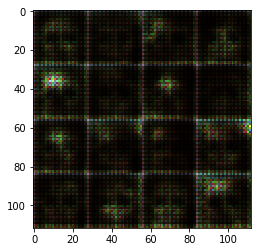

Epoch 1/1... Batch 110... Discriminator Loss: 0.7787... Generator Loss: 0.9055
Epoch 1/1... Batch 120... Discriminator Loss: 0.0396... Generator Loss: 3.9236
Epoch 1/1... Batch 130... Discriminator Loss: 0.3414... Generator Loss: 3.3276
Epoch 1/1... Batch 140... Discriminator Loss: 0.0420... Generator Loss: 6.3650
Epoch 1/1... Batch 150... Discriminator Loss: 0.1249... Generator Loss: 2.8406
Epoch 1/1... Batch 160... Discriminator Loss: 0.2950... Generator Loss: 1.7120
Epoch 1/1... Batch 170... Discriminator Loss: 0.3478... Generator Loss: 2.0691
Epoch 1/1... Batch 180... Discriminator Loss: 0.2507... Generator Loss: 4.3139
Epoch 1/1... Batch 190... Discriminator Loss: 0.3125... Generator Loss: 1.7825
Epoch 1/1... Batch 200... Discriminator Loss: 0.4761... Generator Loss: 1.4125


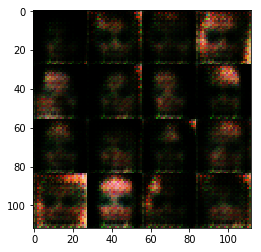

Epoch 1/1... Batch 210... Discriminator Loss: 1.1211... Generator Loss: 1.2168
Epoch 1/1... Batch 220... Discriminator Loss: 1.6073... Generator Loss: 0.3492
Epoch 1/1... Batch 230... Discriminator Loss: 2.9819... Generator Loss: 0.0818
Epoch 1/1... Batch 240... Discriminator Loss: 2.3060... Generator Loss: 0.1587
Epoch 1/1... Batch 250... Discriminator Loss: 2.2350... Generator Loss: 0.2797
Epoch 1/1... Batch 260... Discriminator Loss: 0.9192... Generator Loss: 1.5854
Epoch 1/1... Batch 270... Discriminator Loss: 0.7894... Generator Loss: 2.2692
Epoch 1/1... Batch 280... Discriminator Loss: 0.6472... Generator Loss: 1.4134
Epoch 1/1... Batch 290... Discriminator Loss: 1.7799... Generator Loss: 4.5456
Epoch 1/1... Batch 300... Discriminator Loss: 0.6060... Generator Loss: 1.2888


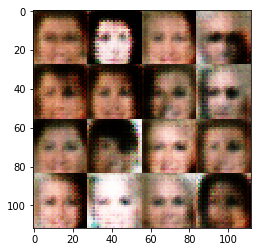

Epoch 1/1... Batch 310... Discriminator Loss: 1.0100... Generator Loss: 1.2339
Epoch 1/1... Batch 320... Discriminator Loss: 1.9992... Generator Loss: 2.8590
Epoch 1/1... Batch 330... Discriminator Loss: 1.4275... Generator Loss: 0.5128
Epoch 1/1... Batch 340... Discriminator Loss: 1.1251... Generator Loss: 0.5391
Epoch 1/1... Batch 350... Discriminator Loss: 0.5454... Generator Loss: 1.8931
Epoch 1/1... Batch 360... Discriminator Loss: 1.6470... Generator Loss: 1.1547
Epoch 1/1... Batch 370... Discriminator Loss: 0.9529... Generator Loss: 0.9586
Epoch 1/1... Batch 380... Discriminator Loss: 0.9815... Generator Loss: 0.6494
Epoch 1/1... Batch 390... Discriminator Loss: 1.1244... Generator Loss: 0.7400
Epoch 1/1... Batch 400... Discriminator Loss: 1.1771... Generator Loss: 0.5771


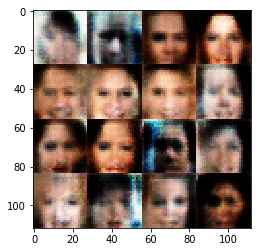

Epoch 1/1... Batch 410... Discriminator Loss: 1.1601... Generator Loss: 3.0452
Epoch 1/1... Batch 420... Discriminator Loss: 0.5371... Generator Loss: 2.5766
Epoch 1/1... Batch 430... Discriminator Loss: 1.1475... Generator Loss: 0.6881
Epoch 1/1... Batch 440... Discriminator Loss: 0.8725... Generator Loss: 0.8221
Epoch 1/1... Batch 450... Discriminator Loss: 0.8194... Generator Loss: 1.9679
Epoch 1/1... Batch 460... Discriminator Loss: 0.8849... Generator Loss: 1.8007
Epoch 1/1... Batch 470... Discriminator Loss: 0.9196... Generator Loss: 0.7562
Epoch 1/1... Batch 480... Discriminator Loss: 0.9676... Generator Loss: 2.5803
Epoch 1/1... Batch 490... Discriminator Loss: 1.2282... Generator Loss: 0.8264
Epoch 1/1... Batch 500... Discriminator Loss: 0.6457... Generator Loss: 1.7947


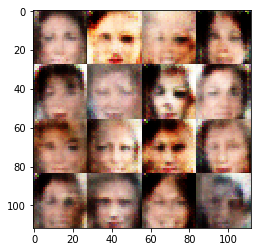

Epoch 1/1... Batch 510... Discriminator Loss: 1.0306... Generator Loss: 1.2324
Epoch 1/1... Batch 520... Discriminator Loss: 1.0634... Generator Loss: 0.9001
Epoch 1/1... Batch 530... Discriminator Loss: 1.0483... Generator Loss: 1.7193
Epoch 1/1... Batch 540... Discriminator Loss: 0.8121... Generator Loss: 2.1262
Epoch 1/1... Batch 550... Discriminator Loss: 0.6965... Generator Loss: 1.4147
Epoch 1/1... Batch 560... Discriminator Loss: 0.9389... Generator Loss: 1.1027
Epoch 1/1... Batch 570... Discriminator Loss: 1.7456... Generator Loss: 0.3264
Epoch 1/1... Batch 580... Discriminator Loss: 1.2585... Generator Loss: 1.3163
Epoch 1/1... Batch 590... Discriminator Loss: 1.3311... Generator Loss: 1.6496
Epoch 1/1... Batch 600... Discriminator Loss: 1.4923... Generator Loss: 2.1642


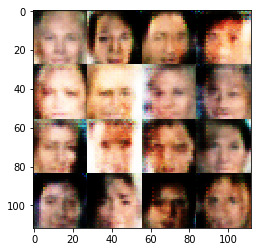

Epoch 1/1... Batch 610... Discriminator Loss: 1.0341... Generator Loss: 0.7276
Epoch 1/1... Batch 620... Discriminator Loss: 0.9348... Generator Loss: 1.6943
Epoch 1/1... Batch 630... Discriminator Loss: 0.7268... Generator Loss: 1.1478
Epoch 1/1... Batch 640... Discriminator Loss: 1.4523... Generator Loss: 1.3183
Epoch 1/1... Batch 650... Discriminator Loss: 1.1401... Generator Loss: 0.9747
Epoch 1/1... Batch 660... Discriminator Loss: 1.3074... Generator Loss: 0.4139
Epoch 1/1... Batch 670... Discriminator Loss: 1.0713... Generator Loss: 0.9085
Epoch 1/1... Batch 680... Discriminator Loss: 0.9321... Generator Loss: 1.0510
Epoch 1/1... Batch 690... Discriminator Loss: 0.7066... Generator Loss: 1.4009
Epoch 1/1... Batch 700... Discriminator Loss: 1.4187... Generator Loss: 0.3789


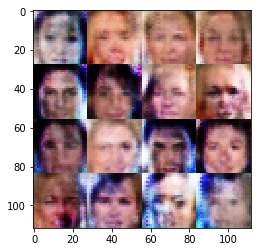

Epoch 1/1... Batch 710... Discriminator Loss: 0.6477... Generator Loss: 1.5764
Epoch 1/1... Batch 720... Discriminator Loss: 0.5494... Generator Loss: 1.2806
Epoch 1/1... Batch 730... Discriminator Loss: 1.5009... Generator Loss: 0.3483
Epoch 1/1... Batch 740... Discriminator Loss: 0.2972... Generator Loss: 3.3814
Epoch 1/1... Batch 750... Discriminator Loss: 0.9065... Generator Loss: 1.1366
Epoch 1/1... Batch 760... Discriminator Loss: 1.2502... Generator Loss: 0.4520
Epoch 1/1... Batch 770... Discriminator Loss: 0.8776... Generator Loss: 0.7571
Epoch 1/1... Batch 780... Discriminator Loss: 1.4317... Generator Loss: 0.8540
Epoch 1/1... Batch 790... Discriminator Loss: 0.7382... Generator Loss: 1.2833
Epoch 1/1... Batch 800... Discriminator Loss: 1.1011... Generator Loss: 1.0260


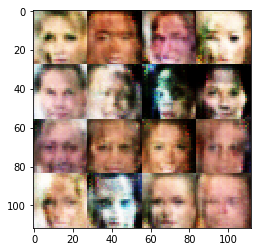

Epoch 1/1... Batch 810... Discriminator Loss: 1.2013... Generator Loss: 0.5586
Epoch 1/1... Batch 820... Discriminator Loss: 0.3622... Generator Loss: 4.0088
Epoch 1/1... Batch 830... Discriminator Loss: 0.5684... Generator Loss: 1.5667
Epoch 1/1... Batch 840... Discriminator Loss: 0.4077... Generator Loss: 2.2836
Epoch 1/1... Batch 850... Discriminator Loss: 0.7377... Generator Loss: 0.8991
Epoch 1/1... Batch 860... Discriminator Loss: 0.4052... Generator Loss: 2.8194
Epoch 1/1... Batch 870... Discriminator Loss: 2.1630... Generator Loss: 0.2291
Epoch 1/1... Batch 880... Discriminator Loss: 1.0338... Generator Loss: 1.0124
Epoch 1/1... Batch 890... Discriminator Loss: 1.3153... Generator Loss: 1.2775
Epoch 1/1... Batch 900... Discriminator Loss: 0.8171... Generator Loss: 1.3693


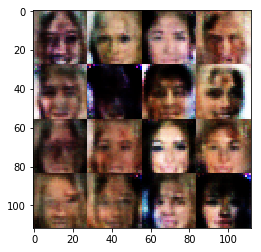

Epoch 1/1... Batch 910... Discriminator Loss: 1.1495... Generator Loss: 3.4411
Epoch 1/1... Batch 920... Discriminator Loss: 1.7806... Generator Loss: 1.4986
Epoch 1/1... Batch 930... Discriminator Loss: 1.2144... Generator Loss: 1.5110
Epoch 1/1... Batch 940... Discriminator Loss: 1.6028... Generator Loss: 0.3544
Epoch 1/1... Batch 950... Discriminator Loss: 0.8822... Generator Loss: 1.0203
Epoch 1/1... Batch 960... Discriminator Loss: 0.6606... Generator Loss: 1.2383
Epoch 1/1... Batch 970... Discriminator Loss: 1.0932... Generator Loss: 1.5640
Epoch 1/1... Batch 980... Discriminator Loss: 1.5364... Generator Loss: 0.3301
Epoch 1/1... Batch 990... Discriminator Loss: 0.9806... Generator Loss: 0.9733
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2977... Generator Loss: 0.5774


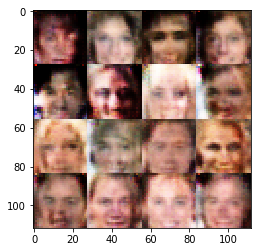

Epoch 1/1... Batch 1010... Discriminator Loss: 0.7921... Generator Loss: 1.0061
Epoch 1/1... Batch 1020... Discriminator Loss: 0.8041... Generator Loss: 0.7487
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3561... Generator Loss: 0.9137
Epoch 1/1... Batch 1040... Discriminator Loss: 1.0932... Generator Loss: 0.9763
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4458... Generator Loss: 0.4501
Epoch 1/1... Batch 1060... Discriminator Loss: 1.1036... Generator Loss: 1.0956
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2018... Generator Loss: 3.5628
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4678... Generator Loss: 0.5952
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2081... Generator Loss: 0.7629
Epoch 1/1... Batch 1100... Discriminator Loss: 1.0468... Generator Loss: 1.4711


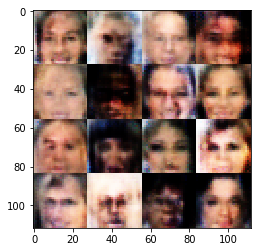

Epoch 1/1... Batch 1110... Discriminator Loss: 1.0743... Generator Loss: 1.9307
Epoch 1/1... Batch 1120... Discriminator Loss: 0.7879... Generator Loss: 1.7812
Epoch 1/1... Batch 1130... Discriminator Loss: 1.0907... Generator Loss: 3.0293
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2786... Generator Loss: 0.4191
Epoch 1/1... Batch 1150... Discriminator Loss: 1.2933... Generator Loss: 0.4767
Epoch 1/1... Batch 1160... Discriminator Loss: 1.3385... Generator Loss: 0.5775
Epoch 1/1... Batch 1170... Discriminator Loss: 0.7330... Generator Loss: 1.3092
Epoch 1/1... Batch 1180... Discriminator Loss: 0.3128... Generator Loss: 3.2066
Epoch 1/1... Batch 1190... Discriminator Loss: 1.7975... Generator Loss: 0.8154
Epoch 1/1... Batch 1200... Discriminator Loss: 0.6679... Generator Loss: 2.6065


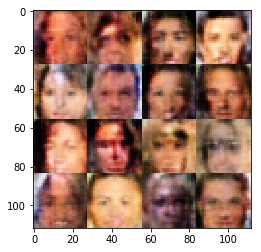

Epoch 1/1... Batch 1210... Discriminator Loss: 1.4132... Generator Loss: 0.5049
Epoch 1/1... Batch 1220... Discriminator Loss: 0.8453... Generator Loss: 1.3530
Epoch 1/1... Batch 1230... Discriminator Loss: 0.7260... Generator Loss: 1.0725
Epoch 1/1... Batch 1240... Discriminator Loss: 0.9904... Generator Loss: 0.9859
Epoch 1/1... Batch 1250... Discriminator Loss: 0.5755... Generator Loss: 1.7477
Epoch 1/1... Batch 1260... Discriminator Loss: 0.7262... Generator Loss: 0.9494
Epoch 1/1... Batch 1270... Discriminator Loss: 0.5091... Generator Loss: 2.3215
Epoch 1/1... Batch 1280... Discriminator Loss: 0.8459... Generator Loss: 1.0358
Epoch 1/1... Batch 1290... Discriminator Loss: 0.3802... Generator Loss: 2.9836
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9225... Generator Loss: 1.5131


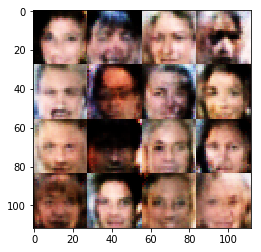

Epoch 1/1... Batch 1310... Discriminator Loss: 0.7338... Generator Loss: 1.5754
Epoch 1/1... Batch 1320... Discriminator Loss: 0.5596... Generator Loss: 1.6792
Epoch 1/1... Batch 1330... Discriminator Loss: 1.8732... Generator Loss: 0.2117
Epoch 1/1... Batch 1340... Discriminator Loss: 0.7876... Generator Loss: 0.9714
Epoch 1/1... Batch 1350... Discriminator Loss: 0.6586... Generator Loss: 0.9963
Epoch 1/1... Batch 1360... Discriminator Loss: 1.3032... Generator Loss: 0.9599
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0224... Generator Loss: 1.0011
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2222... Generator Loss: 0.8017
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8872... Generator Loss: 2.0950
Epoch 1/1... Batch 1400... Discriminator Loss: 0.6527... Generator Loss: 1.6791


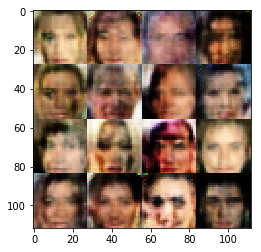

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2903... Generator Loss: 0.4907
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0179... Generator Loss: 0.7864
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0873... Generator Loss: 1.0518
Epoch 1/1... Batch 1440... Discriminator Loss: 1.2733... Generator Loss: 0.4961
Epoch 1/1... Batch 1450... Discriminator Loss: 0.7918... Generator Loss: 0.9244
Epoch 1/1... Batch 1460... Discriminator Loss: 0.4820... Generator Loss: 1.3438
Epoch 1/1... Batch 1470... Discriminator Loss: 0.5634... Generator Loss: 2.8555
Epoch 1/1... Batch 1480... Discriminator Loss: 0.8107... Generator Loss: 1.3193
Epoch 1/1... Batch 1490... Discriminator Loss: 0.5590... Generator Loss: 1.2404
Epoch 1/1... Batch 1500... Discriminator Loss: 0.8765... Generator Loss: 1.2669


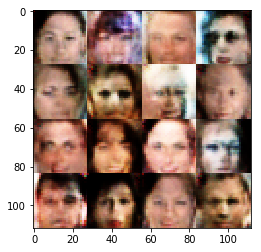

Epoch 1/1... Batch 1510... Discriminator Loss: 1.0780... Generator Loss: 1.1060
Epoch 1/1... Batch 1520... Discriminator Loss: 1.1434... Generator Loss: 0.6641
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1696... Generator Loss: 0.6543
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0944... Generator Loss: 0.5243
Epoch 1/1... Batch 1550... Discriminator Loss: 0.9663... Generator Loss: 1.2233
Epoch 1/1... Batch 1560... Discriminator Loss: 1.5498... Generator Loss: 0.3667
Epoch 1/1... Batch 1570... Discriminator Loss: 0.8736... Generator Loss: 1.3995
Epoch 1/1... Batch 1580... Discriminator Loss: 0.8917... Generator Loss: 0.6999
Epoch 1/1... Batch 1590... Discriminator Loss: 0.9104... Generator Loss: 0.6521
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1589... Generator Loss: 0.5292


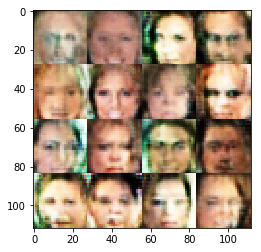

Epoch 1/1... Batch 1610... Discriminator Loss: 1.0657... Generator Loss: 0.7312
Epoch 1/1... Batch 1620... Discriminator Loss: 0.8950... Generator Loss: 0.7582
Epoch 1/1... Batch 1630... Discriminator Loss: 0.9325... Generator Loss: 1.0370
Epoch 1/1... Batch 1640... Discriminator Loss: 0.8966... Generator Loss: 0.8750
Epoch 1/1... Batch 1650... Discriminator Loss: 1.0518... Generator Loss: 0.7607
Epoch 1/1... Batch 1660... Discriminator Loss: 0.7994... Generator Loss: 1.2275
Epoch 1/1... Batch 1670... Discriminator Loss: 2.0378... Generator Loss: 0.2129
Epoch 1/1... Batch 1680... Discriminator Loss: 0.8298... Generator Loss: 1.0008
Epoch 1/1... Batch 1690... Discriminator Loss: 0.9931... Generator Loss: 0.8823
Epoch 1/1... Batch 1700... Discriminator Loss: 2.1449... Generator Loss: 0.1520


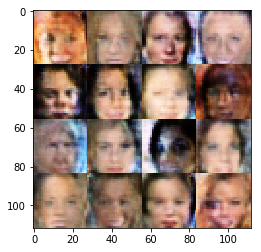

Epoch 1/1... Batch 1710... Discriminator Loss: 1.0021... Generator Loss: 2.0466
Epoch 1/1... Batch 1720... Discriminator Loss: 0.7798... Generator Loss: 1.2203
Epoch 1/1... Batch 1730... Discriminator Loss: 0.4224... Generator Loss: 1.6828
Epoch 1/1... Batch 1740... Discriminator Loss: 0.5655... Generator Loss: 1.1837
Epoch 1/1... Batch 1750... Discriminator Loss: 0.9902... Generator Loss: 1.3053
Epoch 1/1... Batch 1760... Discriminator Loss: 0.6241... Generator Loss: 2.3400
Epoch 1/1... Batch 1770... Discriminator Loss: 0.6718... Generator Loss: 0.9921
Epoch 1/1... Batch 1780... Discriminator Loss: 1.0067... Generator Loss: 1.0136
Epoch 1/1... Batch 1790... Discriminator Loss: 0.9448... Generator Loss: 1.3213
Epoch 1/1... Batch 1800... Discriminator Loss: 0.7813... Generator Loss: 0.9790


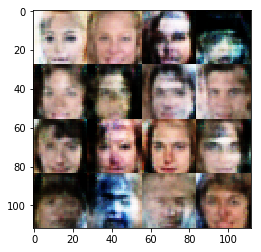

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9242... Generator Loss: 0.8716
Epoch 1/1... Batch 1820... Discriminator Loss: 1.0308... Generator Loss: 0.8035
Epoch 1/1... Batch 1830... Discriminator Loss: 0.9789... Generator Loss: 0.9826
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1799... Generator Loss: 2.1388
Epoch 1/1... Batch 1850... Discriminator Loss: 0.7381... Generator Loss: 1.3392
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2076... Generator Loss: 0.4807
Epoch 1/1... Batch 1870... Discriminator Loss: 1.0202... Generator Loss: 0.9895
Epoch 1/1... Batch 1880... Discriminator Loss: 1.3077... Generator Loss: 0.5725
Epoch 1/1... Batch 1890... Discriminator Loss: 0.8370... Generator Loss: 1.8564
Epoch 1/1... Batch 1900... Discriminator Loss: 1.0778... Generator Loss: 1.9866


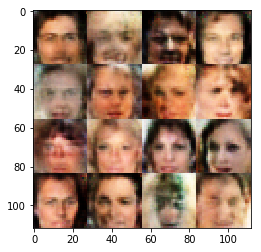

Epoch 1/1... Batch 1910... Discriminator Loss: 1.0656... Generator Loss: 0.5021
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0980... Generator Loss: 1.0896
Epoch 1/1... Batch 1930... Discriminator Loss: 0.9726... Generator Loss: 2.5360
Epoch 1/1... Batch 1940... Discriminator Loss: 0.6488... Generator Loss: 2.5288
Epoch 1/1... Batch 1950... Discriminator Loss: 0.3395... Generator Loss: 3.2582
Epoch 1/1... Batch 1960... Discriminator Loss: 1.0277... Generator Loss: 0.7956
Epoch 1/1... Batch 1970... Discriminator Loss: 0.2729... Generator Loss: 2.1498
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1990... Generator Loss: 0.4944
Epoch 1/1... Batch 1990... Discriminator Loss: 0.8755... Generator Loss: 1.4014
Epoch 1/1... Batch 2000... Discriminator Loss: 0.8470... Generator Loss: 0.6728


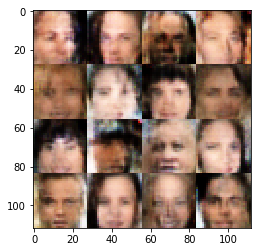

Epoch 1/1... Batch 2010... Discriminator Loss: 1.4227... Generator Loss: 0.3794
Epoch 1/1... Batch 2020... Discriminator Loss: 0.5551... Generator Loss: 1.3414
Epoch 1/1... Batch 2030... Discriminator Loss: 0.4981... Generator Loss: 1.3776
Epoch 1/1... Batch 2040... Discriminator Loss: 0.8145... Generator Loss: 1.0785
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3290... Generator Loss: 0.4082
Epoch 1/1... Batch 2060... Discriminator Loss: 0.8477... Generator Loss: 0.8759
Epoch 1/1... Batch 2070... Discriminator Loss: 0.8904... Generator Loss: 1.6294
Epoch 1/1... Batch 2080... Discriminator Loss: 1.1033... Generator Loss: 0.5796
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2566... Generator Loss: 0.8250
Epoch 1/1... Batch 2100... Discriminator Loss: 0.7650... Generator Loss: 0.8396


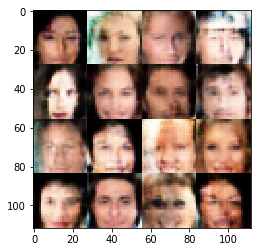

Epoch 1/1... Batch 2110... Discriminator Loss: 1.2256... Generator Loss: 0.9004
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2504... Generator Loss: 2.3056
Epoch 1/1... Batch 2130... Discriminator Loss: 0.5656... Generator Loss: 1.3383
Epoch 1/1... Batch 2140... Discriminator Loss: 1.3968... Generator Loss: 0.8063
Epoch 1/1... Batch 2150... Discriminator Loss: 0.4800... Generator Loss: 1.5723
Epoch 1/1... Batch 2160... Discriminator Loss: 0.9809... Generator Loss: 1.4734
Epoch 1/1... Batch 2170... Discriminator Loss: 0.4252... Generator Loss: 1.5012
Epoch 1/1... Batch 2180... Discriminator Loss: 1.3752... Generator Loss: 0.4591
Epoch 1/1... Batch 2190... Discriminator Loss: 1.2238... Generator Loss: 0.7454
Epoch 1/1... Batch 2200... Discriminator Loss: 1.4584... Generator Loss: 0.3668


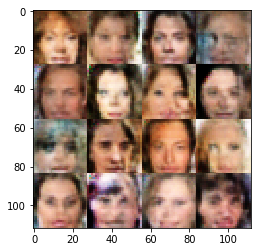

Epoch 1/1... Batch 2210... Discriminator Loss: 0.6196... Generator Loss: 1.6195
Epoch 1/1... Batch 2220... Discriminator Loss: 1.1012... Generator Loss: 0.8037
Epoch 1/1... Batch 2230... Discriminator Loss: 0.8965... Generator Loss: 0.9690
Epoch 1/1... Batch 2240... Discriminator Loss: 0.9376... Generator Loss: 0.7952
Epoch 1/1... Batch 2250... Discriminator Loss: 0.8043... Generator Loss: 0.8755
Epoch 1/1... Batch 2260... Discriminator Loss: 0.4556... Generator Loss: 2.0645
Epoch 1/1... Batch 2270... Discriminator Loss: 0.2953... Generator Loss: 1.9874
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2623... Generator Loss: 0.7599
Epoch 1/1... Batch 2290... Discriminator Loss: 1.2272... Generator Loss: 0.4947
Epoch 1/1... Batch 2300... Discriminator Loss: 0.8250... Generator Loss: 0.9929


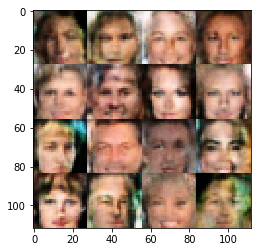

Epoch 1/1... Batch 2310... Discriminator Loss: 0.8725... Generator Loss: 0.7521
Epoch 1/1... Batch 2320... Discriminator Loss: 0.7032... Generator Loss: 0.8667
Epoch 1/1... Batch 2330... Discriminator Loss: 0.7658... Generator Loss: 0.8764
Epoch 1/1... Batch 2340... Discriminator Loss: 0.7673... Generator Loss: 2.8630
Epoch 1/1... Batch 2350... Discriminator Loss: 1.9367... Generator Loss: 0.1811
Epoch 1/1... Batch 2360... Discriminator Loss: 0.4247... Generator Loss: 1.5465
Epoch 1/1... Batch 2370... Discriminator Loss: 0.4516... Generator Loss: 1.7298
Epoch 1/1... Batch 2380... Discriminator Loss: 1.1290... Generator Loss: 1.0143
Epoch 1/1... Batch 2390... Discriminator Loss: 0.2486... Generator Loss: 3.8662
Epoch 1/1... Batch 2400... Discriminator Loss: 1.2371... Generator Loss: 0.4814


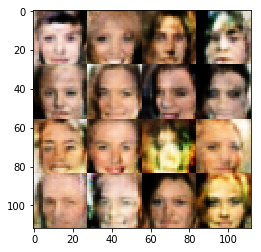

Epoch 1/1... Batch 2410... Discriminator Loss: 1.0591... Generator Loss: 0.7256
Epoch 1/1... Batch 2420... Discriminator Loss: 1.4912... Generator Loss: 1.0745
Epoch 1/1... Batch 2430... Discriminator Loss: 0.6395... Generator Loss: 1.3816
Epoch 1/1... Batch 2440... Discriminator Loss: 1.8666... Generator Loss: 0.2150
Epoch 1/1... Batch 2450... Discriminator Loss: 1.2492... Generator Loss: 0.4619
Epoch 1/1... Batch 2460... Discriminator Loss: 0.5549... Generator Loss: 1.1360
Epoch 1/1... Batch 2470... Discriminator Loss: 0.8690... Generator Loss: 0.8979
Epoch 1/1... Batch 2480... Discriminator Loss: 0.7003... Generator Loss: 1.0542
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2207... Generator Loss: 0.4652
Epoch 1/1... Batch 2500... Discriminator Loss: 0.5835... Generator Loss: 2.4407


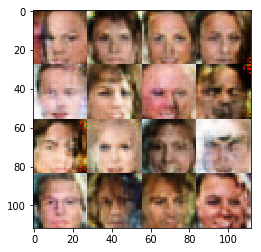

Epoch 1/1... Batch 2510... Discriminator Loss: 1.0044... Generator Loss: 0.5803
Epoch 1/1... Batch 2520... Discriminator Loss: 0.4764... Generator Loss: 2.0124
Epoch 1/1... Batch 2530... Discriminator Loss: 0.8192... Generator Loss: 1.6120
Epoch 1/1... Batch 2540... Discriminator Loss: 0.9780... Generator Loss: 0.6603
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3681... Generator Loss: 3.0286
Epoch 1/1... Batch 2560... Discriminator Loss: 0.8107... Generator Loss: 0.7686
Epoch 1/1... Batch 2570... Discriminator Loss: 0.4734... Generator Loss: 3.3899
Epoch 1/1... Batch 2580... Discriminator Loss: 0.8130... Generator Loss: 0.8740
Epoch 1/1... Batch 2590... Discriminator Loss: 1.3542... Generator Loss: 1.8863
Epoch 1/1... Batch 2600... Discriminator Loss: 1.1500... Generator Loss: 0.6942


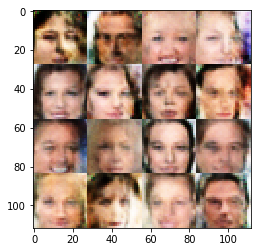

Epoch 1/1... Batch 2610... Discriminator Loss: 0.7688... Generator Loss: 2.0427
Epoch 1/1... Batch 2620... Discriminator Loss: 1.9704... Generator Loss: 2.1705
Epoch 1/1... Batch 2630... Discriminator Loss: 0.6314... Generator Loss: 1.6302
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3101... Generator Loss: 0.4356
Epoch 1/1... Batch 2650... Discriminator Loss: 0.8216... Generator Loss: 1.1110
Epoch 1/1... Batch 2660... Discriminator Loss: 0.4742... Generator Loss: 1.6728
Epoch 1/1... Batch 2670... Discriminator Loss: 0.6156... Generator Loss: 1.3151
Epoch 1/1... Batch 2680... Discriminator Loss: 1.8483... Generator Loss: 0.2256
Epoch 1/1... Batch 2690... Discriminator Loss: 1.1812... Generator Loss: 0.5435
Epoch 1/1... Batch 2700... Discriminator Loss: 0.7934... Generator Loss: 0.8740


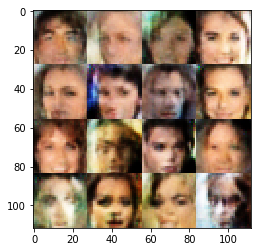

Epoch 1/1... Batch 2710... Discriminator Loss: 1.9084... Generator Loss: 0.2116
Epoch 1/1... Batch 2720... Discriminator Loss: 0.7521... Generator Loss: 1.1842
Epoch 1/1... Batch 2730... Discriminator Loss: 1.2769... Generator Loss: 0.6180
Epoch 1/1... Batch 2740... Discriminator Loss: 1.1357... Generator Loss: 0.5081
Epoch 1/1... Batch 2750... Discriminator Loss: 0.5053... Generator Loss: 1.4015
Epoch 1/1... Batch 2760... Discriminator Loss: 1.3301... Generator Loss: 0.4738
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2113... Generator Loss: 0.8807
Epoch 1/1... Batch 2780... Discriminator Loss: 0.7491... Generator Loss: 0.9152
Epoch 1/1... Batch 2790... Discriminator Loss: 2.8309... Generator Loss: 0.0927
Epoch 1/1... Batch 2800... Discriminator Loss: 1.4776... Generator Loss: 0.3838


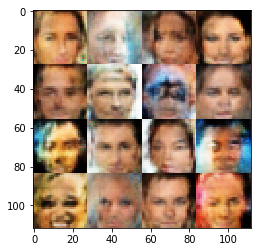

Epoch 1/1... Batch 2810... Discriminator Loss: 0.9791... Generator Loss: 0.6716
Epoch 1/1... Batch 2820... Discriminator Loss: 1.6686... Generator Loss: 1.0884
Epoch 1/1... Batch 2830... Discriminator Loss: 2.3469... Generator Loss: 2.6310
Epoch 1/1... Batch 2840... Discriminator Loss: 0.5169... Generator Loss: 1.5216
Epoch 1/1... Batch 2850... Discriminator Loss: 1.3485... Generator Loss: 0.4769
Epoch 1/1... Batch 2860... Discriminator Loss: 0.7088... Generator Loss: 1.1492
Epoch 1/1... Batch 2870... Discriminator Loss: 0.9242... Generator Loss: 1.6109
Epoch 1/1... Batch 2880... Discriminator Loss: 1.4005... Generator Loss: 0.4378
Epoch 1/1... Batch 2890... Discriminator Loss: 0.9388... Generator Loss: 0.9549
Epoch 1/1... Batch 2900... Discriminator Loss: 1.2214... Generator Loss: 0.5501


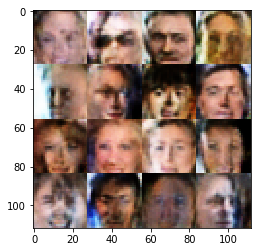

Epoch 1/1... Batch 2910... Discriminator Loss: 0.9500... Generator Loss: 0.8017
Epoch 1/1... Batch 2920... Discriminator Loss: 1.1021... Generator Loss: 0.8738
Epoch 1/1... Batch 2930... Discriminator Loss: 0.8572... Generator Loss: 0.9434
Epoch 1/1... Batch 2940... Discriminator Loss: 0.2628... Generator Loss: 2.9914
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2291... Generator Loss: 0.9504
Epoch 1/1... Batch 2960... Discriminator Loss: 1.9184... Generator Loss: 0.1965
Epoch 1/1... Batch 2970... Discriminator Loss: 0.9847... Generator Loss: 0.7817
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1764... Generator Loss: 0.5593
Epoch 1/1... Batch 2990... Discriminator Loss: 1.1348... Generator Loss: 0.7210
Epoch 1/1... Batch 3000... Discriminator Loss: 0.3717... Generator Loss: 2.0583


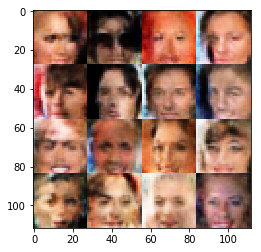

Epoch 1/1... Batch 3010... Discriminator Loss: 0.6970... Generator Loss: 1.2292
Epoch 1/1... Batch 3020... Discriminator Loss: 0.8602... Generator Loss: 0.6960
Epoch 1/1... Batch 3030... Discriminator Loss: 0.3654... Generator Loss: 1.9217
Epoch 1/1... Batch 3040... Discriminator Loss: 1.5219... Generator Loss: 2.5815
Epoch 1/1... Batch 3050... Discriminator Loss: 0.6389... Generator Loss: 1.3416
Epoch 1/1... Batch 3060... Discriminator Loss: 1.0335... Generator Loss: 0.8812
Epoch 1/1... Batch 3070... Discriminator Loss: 0.9407... Generator Loss: 0.6701
Epoch 1/1... Batch 3080... Discriminator Loss: 1.7771... Generator Loss: 2.1377
Epoch 1/1... Batch 3090... Discriminator Loss: 2.4766... Generator Loss: 3.1224
Epoch 1/1... Batch 3100... Discriminator Loss: 1.1108... Generator Loss: 1.5078


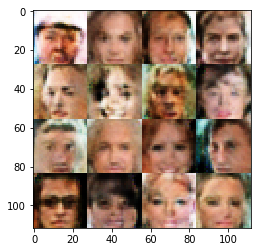

Epoch 1/1... Batch 3110... Discriminator Loss: 0.9626... Generator Loss: 0.7548
Epoch 1/1... Batch 3120... Discriminator Loss: 1.7998... Generator Loss: 0.2216
Epoch 1/1... Batch 3130... Discriminator Loss: 1.5248... Generator Loss: 1.1686
Epoch 1/1... Batch 3140... Discriminator Loss: 1.3434... Generator Loss: 0.4292
Epoch 1/1... Batch 3150... Discriminator Loss: 1.1187... Generator Loss: 0.5084
Epoch 1/1... Batch 3160... Discriminator Loss: 1.5491... Generator Loss: 1.5132


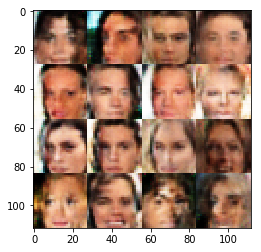

In [41]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.